# Cosmic-ray flux vs. sky position

In [1]:
%load_ext watermark
%watermark -u -d -v -p numpy,scipy,pandas,sklearn,mlxtend

last updated: 2018-08-21 

CPython 2.7.13
IPython 5.7.0

numpy 1.14.5
scipy 1.1.0
pandas 0.23.1
sklearn 0.19.1
mlxtend 0.12.0


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from __future__ import division, print_function
import os
import sys
from numbers import Number
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
import dask
from dask import delayed, compute
from dask.diagnostics import ProgressBar
import dask.array as da
import pyunfold

import comptools as comp
import sky_anisotropy as sa

color_dict = comp.color_dict

sns.set_context(context='paper', font_scale=1.5)

%matplotlib inline

In [4]:
config = 'IC86.2012'
num_groups = 2

comp_list = comp.get_comp_list(num_groups=num_groups)
analysis_bins = comp.get_bins(config=config, num_groups=num_groups)
energybins = comp.get_energybins(config)
num_ebins = len(energybins.log_energy_midpoints)

unfolding_dir  = os.path.join(comp.paths.comp_data_dir,
                              config,
                              'unfolding')

In [5]:
# Load DataFrame with saved prior distributions
df_file = os.path.join(unfolding_dir,
                       'unfolding-df_{}-groups.hdf'.format(num_groups))
df_priors = pd.read_hdf(df_file)
df_priors.head()

,counts,counts_err,efficiencies,efficiencies_err,broken_power_law_flux,broken_power_law_prior,simple_power_law_flux,simple_power_law_prior,H3a_flux,H3a_prior,H4a_flux,H4a_prior
log_energy_bin_idx,,,,,,,,,,,,
0,1071404.0,1035.086470,0.007119,0.000084,1.416780e-12,0.231674,1.416780e-12,0.231486,7.187420e-13,0.302586,7.333020e-13,0.306455
1,743932.0,862.514927,0.006400,0.000078,1.416780e-12,0.231674,1.416780e-12,0.231486,4.082709e-13,0.171880,4.023280e-13,0.168137
2,851277.0,922.646736,0.007928,0.000075,7.608561e-13,0.124416,7.608561e-13,0.124315,3.743101e-13,0.157582,3.821589e-13,0.159708
3,702982.0,838.440219,0.007473,0.000068,7.608561e-13,0.124416,7.608561e-13,0.124315,2.232925e-13,0.094005,2.198728e-13,0.091887
4,579872.0,761.493270,0.008373,0.000068,4.086039e-13,0.066816,4.086039e-13,0.066761,1.925426e-13,0.081059,1.967681e-13,0.082231


In [6]:
# Load simulation and train composition classifier
df_sim_train, df_sim_test = comp.load_sim(config=config,
                                          energy_reco=False,
                                          log_energy_min=None,
                                          log_energy_max=None,
                                          test_size=0.5,
                                          n_jobs=10,
                                          verbose=True)

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/dask/base.py:835: UserWarning: The get= keyword has been deprecated. Please use the scheduler= keyword instead with the name of the desired scheduler like 'threads' or 'processes'
  warnings.warn("The get= keyword has been deprecated. "


[########################################] | 100% Completed |  6.8s
[########################################] | 100% Completed |  0.1s


In [7]:
feature_list, feature_labels = comp.get_training_features()

In [8]:
print('Running energy reconstruction...')
energy_pipeline_name = 'linearregression'
# energy_pipeline_name = 'RF'
energy_pipeline = comp.load_trained_model('{}_energy_{}'.format(energy_pipeline_name, config))
for df in [df_sim_train, df_sim_test]:
    # Energy reconstruction
    df['reco_log_energy'] = energy_pipeline.predict(df[feature_list].values)
    df['reco_energy'] = 10**df['reco_log_energy']

Running energy reconstruction...


In [9]:
# Load fitted efficiencies and calculate effective areas
# eff_path = os.path.join(comp.paths.comp_data_dir, config, 'efficiencies',
#                         'efficiency_fit_num_groups_{}.hdf'.format(num_groups))
eff_path = comp.get_efficiencies_file(config=config,
                                      num_groups=num_groups,
                                      sigmoid='slant')
df_eff = pd.read_hdf(eff_path)
df_eff.head()

,eff_median_light,eff_err_low_light,eff_err_high_light,eff_median_heavy,eff_err_low_heavy,eff_err_high_heavy,eff_median_total,eff_err_low_total,eff_err_high_total
0,0.007116,0.000083,0.000084,0.006401,0.000086,0.000076,0.006736,0.000051,0.000058
1,0.007926,0.000072,0.000065,0.007473,0.000066,0.000069,0.007684,0.000045,0.000047
2,0.008371,0.000065,0.000067,0.008009,0.000065,0.000063,0.008192,0.000043,0.000047
3,0.008609,0.000071,0.000062,0.008274,0.000068,0.000064,0.008456,0.000045,0.000048
4,0.008735,0.000072,0.000067,0.008426,0.000066,0.000064,0.008601,0.000045,0.000049


In [10]:
# Get simulation thrown areas for each energy bin
thrown_radii = comp.simfunctions.get_sim_thrown_radius(energybins.log_energy_midpoints)
thrown_area = np.max(np.pi * thrown_radii**2)
thrown_area

9079202.768874502

In [11]:
efficiencies, efficiencies_err = comp.get_detector_efficiencies(config=config,
                                                                num_groups=num_groups,
                                                                sigmoid='slant',
                                                                pyunfold_format=True)

In [12]:
efficiencies

array([0.00711621, 0.00640114, 0.00792564, 0.00747336, 0.00837118,
       0.00800932, 0.00860879, 0.00827434, 0.00873487, 0.00842553,
       0.00880808, 0.00853552, 0.00885811, 0.00862577, 0.00889926,
       0.00871167, 0.00893319, 0.00879576, 0.00896376, 0.0088786 ,
       0.00899596, 0.00896131, 0.00902511, 0.00904439, 0.00905524,
       0.00912615, 0.00908302, 0.00920706, 0.00911336, 0.00928806,
       0.00914197, 0.00936856, 0.00917137, 0.00944958, 0.009201  ,
       0.00953194, 0.00922881, 0.00961275])

In [25]:
print('Running composition classifications...')
# pipeline_str = 'SGD_comp_{}_{}-groups'.format(config, num_groups)
pipeline_str = 'xgboost_comp_{}_{}-groups'.format(config, num_groups)
comp_pipeline = comp.load_trained_model(pipeline_str)
pred_target = comp_pipeline.predict(df_sim_test[feature_list].values)

Running composition classifications...


/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [26]:
df_sim_test['pred_comp_target'] = pred_target

In [27]:
print('Making response matrix...')
log_reco_energy_sim_test = df_sim_test['reco_log_energy']
log_true_energy_sim_test = df_sim_test['MC_log_energy']
true_target = df_sim_test['comp_target_{}'.format(num_groups)].values

response, response_err = comp.response_matrix(true_energy=log_true_energy_sim_test,
                                              reco_energy=log_reco_energy_sim_test,
                                              true_target=true_target,
                                              pred_target=pred_target,
                                              efficiencies=efficiencies,
                                              efficiencies_err=efficiencies_err,
                                              energy_bins=energybins.log_energy_bins)

Making response matrix...


In [28]:
np.testing.assert_allclose(response.sum(axis=0), efficiencies)

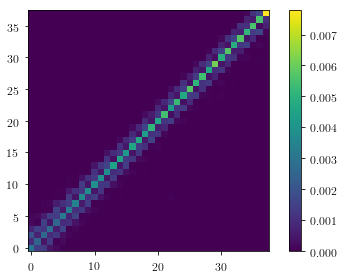

In [29]:
plt.imshow(response, origin='lower')
plt.colorbar()
plt.show()

In [30]:
# print('Loading data into memory...')
# df_data = comp.load_data(config=config,
#                          energy_reco=True,
#                          log_energy_min=6.1,
#                          log_energy_max=8.0,
#                          columns=feature_list + ['lap_ra', 'lap_dec'],
#                          n_jobs=20,
#                          verbose=True)

In [31]:
# df_data.to_hdf('data_dataframe.hdf', 'dataframe', format='table')

In [32]:
df_data = pd.read_hdf('data_dataframe.hdf', 'dataframe', mode='r')

In [33]:
df_data.shape

(6960257, 7)

In [34]:
energybins.log_energy_bins

array([6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3,
       7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8. ])

In [35]:
df_data.reco_log_energy.min(), df_data.reco_log_energy.max()

(6.100000018173085, 7.9997100892394135)

In [36]:
print('Running energy reconstruction...')
for df in [df_data]:
    # Energy reconstruction
    df['reco_log_energy'] = energy_pipeline.predict(df[feature_list].values)
    df['reco_energy'] = 10**df['reco_log_energy']

Running energy reconstruction...


In [37]:
df_data.reco_log_energy.min(), df_data.reco_log_energy.max()

(6.100000018173085, 7.9997100892394135)

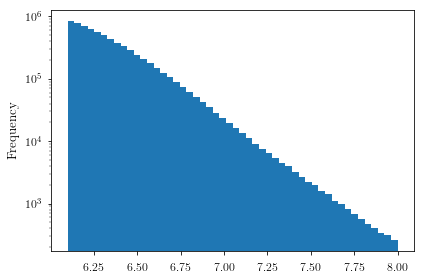

In [38]:
fig, ax = plt.subplots()
df_data.reco_log_energy.plot(kind='hist', bins=50, ax=ax)
ax.set(yscale='log')
plt.show()

### Data declination distribution

In [39]:
ra = df_data.loc[:, 'lap_ra'].values
dec = df_data.loc[:, 'lap_dec'].values

In [40]:
dec_median = df_data.loc[:, 'lap_dec'].median()
dec_median_deg = np.rad2deg(dec_median)

dec_median = -1.30333228859 [rad]
dec_median = -74.6754394391 [deg]


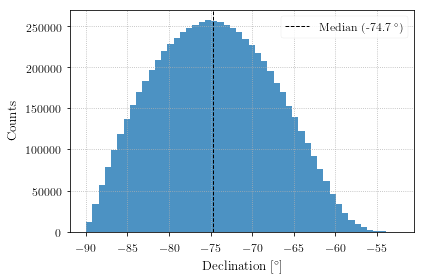

In [29]:
fig, ax = plt.subplots()
ax.hist(np.rad2deg(dec), bins=50, alpha=0.8)
print('dec_median = {} [rad]'.format(dec_median))
print('dec_median = {} [deg]'.format(dec_median_deg))
ax.axvline(dec_median_deg, marker='None', ls='--', lw=1, color='k',
           label='Median ({:0.1f}'.format(dec_median_deg)+' $^{\circ}$)')
# ax.set_yscale('log', nonposy='clip')
ax.set_xlabel('Declination [$^{\circ}$]')
ax.set_ylabel('Counts')
ax.grid()
ax.legend()
outfile = os.path.join(comp.paths.figures_dir, 'skymaps', 'declination_hist.png')
comp.check_output_dir(outfile)
plt.savefig(outfile)
plt.show()

### Flux vs. declination 

In [41]:
import dask.array as da

X_data = da.from_array(df_data[feature_list].values, chunks=int(1e4))
X_data

dask.array<array, shape=(6960257, 3), dtype=float64, chunksize=(10000, 3)>

In [42]:
from dask_ml.wrappers import ParallelPostFit
from dask.diagnostics import ProgressBar

pred_comp_target = ParallelPostFit(comp_pipeline).predict(X_data)
reco_log_energy = ParallelPostFit(energy_pipeline).predict(X_data)

In [43]:
import warnings

with ProgressBar() as _, warnings.catch_warnings() as _:
    warnings.simplefilter("ignore") # Wan to ignore xgboost DeprecationWarning
    print('Running composition classifications...')
    df_data['pred_comp_target'] = pred_comp_target.compute(schuduler='threads', 
                                                           num_workers=20)
#     df_data['pred_comp_target'] = pred_comp_target.compute()

Running composition classifications...
[########################################] | 100% Completed |  5.6s
[########################################] | 100% Completed |  0.1s


In [44]:
# print('Running energy and composition reconstructions...')
# df_data['pred_comp_target'] = comp_pipeline.predict(df_data[feature_list].values)
# df_data['reco_log_energy'] = energy_pipeline.predict(df_data[feature_list].values)

In [45]:
# Effective area
eff_area, eff_area_err = {}, {}
for composition in comp_list+['total']:
    eff_area[composition] = df_eff['eff_median_{}'.format(composition)].values * thrown_area
    eff_area_err[composition] = df_eff['eff_err_low_{}'.format(composition)].values * thrown_area
    
# Livetime
livetime, livetime_err = comp.get_detector_livetime(config=config)

In [46]:
df_eff['eff_median_total'].values

array([0.0067357 , 0.00768392, 0.00819213, 0.00845571, 0.00860106,
       0.00869518, 0.00876493, 0.00882504, 0.00888223, 0.00893701,
       0.00899151, 0.00904821, 0.00910125, 0.00915483, 0.00920796,
       0.00926119, 0.00931638, 0.00937015, 0.00942275])

In [47]:
np.rad2deg(np.arccos(df_data.lap_cos_zenith.max())), np.rad2deg(np.arccos(df_data.lap_cos_zenith.min()))

(0.0048982721856552, 37.65427444520522)

In [48]:
def calc_solid_angle(theta_min=0, theta_max=np.pi/2):
    return 2*np.pi*(np.cos(theta_min) - np.cos(theta_max))

def calc_geom_factor(theta_min=0, theta_max=np.pi/2):
    return (np.cos(theta_min) + np.cos(theta_max)) / 2

In [49]:
efficiencies

array([0.00711621, 0.00640114, 0.00792564, 0.00747336, 0.00837118,
       0.00800932, 0.00860879, 0.00827434, 0.00873487, 0.00842553,
       0.00880808, 0.00853552, 0.00885811, 0.00862577, 0.00889926,
       0.00871167, 0.00893319, 0.00879576, 0.00896376, 0.0088786 ,
       0.00899596, 0.00896131, 0.00902511, 0.00904439, 0.00905524,
       0.00912615, 0.00908302, 0.00920706, 0.00911336, 0.00928806,
       0.00914197, 0.00936856, 0.00917137, 0.00944958, 0.009201  ,
       0.00953194, 0.00922881, 0.00961275])

In [50]:
np.pi*np.sin(np.deg2rad(40))**2

1.2980304071610544

## Cosmic-ray flux vs. sky position

### Sample on/off regions

In [51]:
import sky_anisotropy as sa
from scipy import stats
from scipy.special import erfcinv

In [52]:
nside = 64
npix = hp.nside2npix(nside)
size = np.deg2rad(5)

In [53]:
ra = df_data.loc[:, 'lap_ra'].values
dec = df_data.loc[:, 'lap_dec'].values

In [54]:
# maps = []
# for i in range(20):
#     print(i)
#     ra_random = df_data.loc[:, 'lap_ra'].sample(frac=1.0, random_state=i).values
#     theta_random, phi_random = comp.equatorial_to_healpy(ra_random, dec)
#     pix_random = hp.ang2pix(nside, theta_random, phi_random)
    
#     data_skymap_random = np.zeros(npix)
#     unique_pix, pix_counts = np.unique(pix_random, return_counts=True)
#     data_skymap_random[unique_pix] += pix_counts
#     maps.append(data_skymap_random)

In [55]:
# ref = np.mean(maps, axis=0)
# ref

In [56]:
# comp.plot_skymap(ref, polar=True)
# plt.show()

Convert from ra/dec equatorial coordinates to the theta/phi coordinates used in healpy

In [57]:
theta, phi = comp.equatorial_to_healpy(ra, dec)

Calculate the healpix map pixel for each data event

In [58]:
pix_array = hp.ang2pix(nside, theta, phi)
df_data['pix'] = pix_array

In [59]:
data_skymap = np.zeros(npix)
unique_pix, pix_counts = np.unique(pix_array, return_counts=True)
data_skymap[unique_pix] += pix_counts

In [60]:
# ri = (data_skymap - ref) / ref
# ri = comp.mapfunctions.smooth_map(ri)

# theta, phi = hp.pix2ang(nside, list(range(npix)))
# ra, dec = sa.healpy_to_equatorial(theta, phi)

# dec_max_deg = -65
# dec_mask = dec < np.deg2rad(dec_max_deg)
# ri[~dec_mask] = hp.UNSEEN

# comp.plot_skymap(ri, polar=True)
# plt.show()

/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/healpy/projector.py:750: RuntimeWarning: invalid value encountered in greater
  mask = (np.asarray(x)**2+np.asarray(y)**2>1.0)
/home/jbourbeau/cr-composition/.virtualenv/lib/python2.7/site-packages/healpy/projaxes.py:387: RuntimeWarning: invalid value encountered in greater
  w=np.where(d2 > threshold)[0]


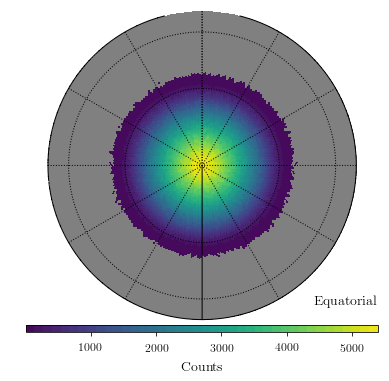

In [61]:
data_skymap[data_skymap == 0] = hp.UNSEEN
comp.plot_skymap(data_skymap, cbar_title='Counts', polar=True)
# plt.title('IC86.2012 data')
outfile = os.path.join(comp.paths.figures_dir,
                       'spectrum-anisotropy',
                       '{}-data-skymap-polar.png'.format(config))
comp.check_output_dir(outfile)
plt.savefig(outfile)
plt.show()

In [62]:
# ra_test = np.deg2rad(34)
# dec_test = np.deg2rad(-70)

ra_test = np.deg2rad(34)
dec_test = np.deg2rad(-80)

theta_test, phi_test = sa.equatorial_to_healpy(ra_test, dec_test)
pix_test = hp.ang2pix(nside, theta_test, phi_test)

# pix_in_disc = sa.regions.disc_on_region(pix_test, size=size, nside=nside)
pix_in_disc = sa.regions.square_on_region(pix_test, size=size, nside=nside)

In [63]:
p = np.arange(npix)

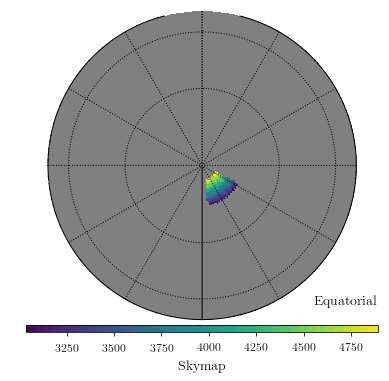

In [64]:
on_region_skymap = data_skymap.copy()
in_on_region = np.isin(p, pix_in_disc)
on_region_skymap[~in_on_region] = hp.UNSEEN

comp.plot_skymap(on_region_skymap, polar=True)
outfile = os.path.join(comp.paths.figures_dir,
                       'spectrum-anisotropy',
                       '{}-on-region-skymap-polar.png'.format(config))
comp.check_output_dir(outfile)
plt.savefig(outfile)
plt.show()

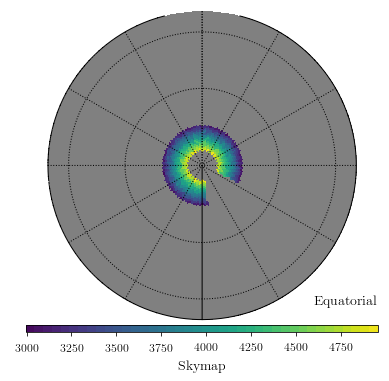

In [65]:
off_region_skymap = data_skymap.copy()
off_region_pix = sa.regions.theta_band_off_region(pix_in_disc, nside=64)
in_off_region = np.isin(p, off_region_pix)
off_region_skymap[~in_off_region] = hp.UNSEEN
off_region_skymap[off_region_skymap == 0] = hp.UNSEEN

comp.plot_skymap(off_region_skymap, polar=True)

outfile = os.path.join(comp.paths.figures_dir,
                       'spectrum-anisotropy',
                       '{}-off-region-skymap-polar.png'.format(config))
comp.check_output_dir(outfile)
plt.savefig(outfile)
plt.show()

### Spectrum anisotropy skymap

In [66]:
theta, phi = hp.pix2ang(nside, list(range(npix)))
ra, dec = sa.healpy_to_equatorial(theta, phi)

# dec_max_deg = -60
dec_max_deg = -65
# dec_max_deg = -80
# dec_max_deg = -84
print('dec_max_deg = {}'.format(dec_max_deg))

size = np.deg2rad(5)
print('size = {:0.2f} [deg]'.format(np.rad2deg(size)))

ebins = np.arange(6.4, 7.9, 0.1)
# ebins = np.arange(6.4, 7.5, 0.1)
# ebins = np.concatenate([ebins, [7.8]])

on_region = 'disc'
# on_region = 'square'
print('on_region = {}'.format(on_region))

# off_region = 'allsky'
off_region = 'theta_band'
# off_region = 'opposite'
print('off_region = {}'.format(off_region))

# key = 'log_s125'
key = 'reco_log_energy'
print('key = {}'.format(key))

# with_unfolding = True
with_unfolding = False

has_data = dec < np.deg2rad(dec_max_deg)
if off_region == 'theta_band':
    has_data = has_data & (dec > np.deg2rad(-90) + size)
    
has_data.sum()

dec_max_deg = -65
size = 5.00 [deg]
on_region = disc
off_region = theta_band
key = reco_log_energy


2160

In [67]:
figures_outdir = os.path.join(comp.paths.figures_dir,
                              'spectrum-anisotropy',
                              '{}-on-{}-off-{:0.0f}deg-size'.format(on_region, off_region, np.rad2deg(size)),
                              'unfolded' if with_unfolding else 'pre-unfolding',
                             )
print('figures_outdir = {}'.format(figures_outdir))

figures_outdir = /home/jbourbeau/public_html/figures/composition/spectrum-anisotropy/disc-on-theta_band-off-5deg-size/pre-unfolding


In [68]:
pix_disc = np.arange(npix)[has_data]
pix_disc.shape

(2160,)

In [69]:
data = df_data.loc[:, ['reco_log_energy', 'pred_comp_target']].values
pix = df_data.loc[:, 'pix'].values
# pix = df_data.loc[:, 'pix'].sample(frac=1.0).values

binned_skymaps = sa.binned_skymaps(data=data,
                                   pix=pix,
                                   bins=analysis_bins,
                                   nside=nside)

In [70]:
binned_skymaps

array([[[   0,    0,    0, ..., 1085,  999, 1039],
        [   0,    0,    0, ...,  652,  612,  562]],

       [[   0,    0,    0, ...,  449,  519,  489],
        [   0,    0,    0, ...,  730,  680,  768]],

       [[   0,    0,    0, ...,  259,  267,  267],
        [   0,    0,    0, ...,  590,  579,  569]],

       ...,

       [[   0,    0,    0, ...,    1,    0,    0],
        [   0,    0,    0, ...,    0,    1,    1]],

       [[   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    1,    0,    1]],

       [[   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    1,    0,    0]]])

In [71]:
if with_unfolding:
    def unfolding_func(counts, composition='total'):
        original_shape = counts.shape
        counts_err = np.sqrt(counts)
        unfolded_results = pyunfold.iterative_unfold(data=counts.reshape(-1),
                                                     data_err=counts_err.reshape(-1),
                                                     response=response,
                                                     response_err=response_err,
                                                     efficiencies=efficiencies.reshape(-1),
                                                     efficiencies_err=efficiencies_err.reshape(-1),
                                                     ts='ks',
                                                     ts_stopping=0.005,
                                                     return_iterations=True,
                                                    )
        counts, counts_sys_err, counts_stat_err = comp.unfolded_counts_dist(unfolded_results,
                                                                            num_groups=num_groups)

        eff = df_eff['eff_median_{}'.format(composition)].values
        counts = counts[composition] * eff
        counts_err = counts_stat_err[composition] * eff

        unfolding_energy_range_mask = np.logical_and(energybins.log_energy_midpoints >= 6.4,
                                                     energybins.log_energy_midpoints <= 7.8)

        return counts[unfolding_energy_range_mask], counts_err[unfolding_energy_range_mask]
else:
    def unfolding_func(counts, composition='total'):
        original_shape = counts.shape
        counts_err = np.sqrt(counts)

        counts_total = counts.sum(axis=1)
        counts_err_total = np.sqrt(np.sum(counts_err**2, axis=1))

        unfolding_energy_range_mask = np.logical_and(energybins.log_energy_midpoints >= 6.4,
                                                     energybins.log_energy_midpoints <= 7.8)


        return counts_total[unfolding_energy_range_mask], counts_err_total[unfolding_energy_range_mask]

In [72]:
from sky_anisotropy.core import on_off_chi_squared_single

counts_on_test, counts_on_err_test, counts_off_test, counts_off_err_test = sa.on_off_distributions(
                          binned_maps=binned_skymaps,
                          pix_center=pix_test,
                          on_region=on_region,
                          size=size,
                          off_region=off_region,
                          nside=nside,
                          hist_func=unfolding_func)

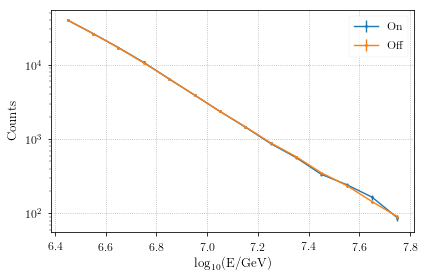

In [73]:
unfolded_counts_on_test = counts_on_test
unfolded_counts_on_err_test = counts_on_err_test
unfolded_counts_off_test = counts_off_test
unfolded_counts_off_err_test = counts_off_err_test

alpha = np.sum(unfolded_counts_on_test) / np.sum(unfolded_counts_off_test)
scaled_unfolded_counts_off_test = alpha * unfolded_counts_off_test
scaled_unfolded_counts_off_err_test = alpha * unfolded_counts_off_err_test

x = comp.binning.bin_edges_to_midpoints(np.arange(6.4, 7.9, 0.1))

fig, ax = plt.subplots()
ax.errorbar(x,
            unfolded_counts_on_test,
            unfolded_counts_on_err_test,
            label='On',
            color='C0')
ax.errorbar(x,
            scaled_unfolded_counts_off_test,
            scaled_unfolded_counts_off_err_test,
            label='Off',
            color='C1')

ax.set(ylabel='Counts',
       xlabel='$\mathrm{\log_{10}(E/GeV)}$',
       yscale='log')
ax.grid()
ax.legend()

outfile = os.path.join(figures_outdir,
                       'test-unfolded-counts.png')
comp.check_output_dir(outfile)
plt.savefig(outfile)

plt.show()

In [74]:
num_workers = min(len(pix_disc), 25)
scheduler = 'multiprocessing' if with_unfolding else 'threads'

with dask.config.set(scheduler=scheduler, num_workers=num_workers) as _, ProgressBar() as _:   
    results = sa.on_off_chi_squared(binned_maps=binned_skymaps,
                                    pix_center=pix_disc,
                                    on_region=on_region,
                                    size=size,
                                    off_region=off_region,
                                    nside=nside,
                                    hist_func=unfolding_func,
                                    )

[########################################] | 100% Completed |  4.7s
[########################################] | 100% Completed |  0.1s


In [75]:
results.shape

(2160, 7)

In [76]:
results.head()

,alpha,chi2,ndof,num_on,pix_center,pval,sig
0,0.058221,11.539888,14,35179,46908,0.643200,-0.367025
1,0.059241,11.417012,14,35761,46909,0.653010,-0.393461
2,0.060353,11.834221,14,36394,46910,0.619614,-0.304468
3,0.059453,16.691543,14,35882,46911,0.272989,0.603799
4,0.058536,15.874409,14,35359,46912,0.321104,0.464614


In [77]:
outdir = os.path.join(os.getcwd(),
                      'results',
                      'unfolded' if with_unfolding else 'pre-unfolding')
print('outdir = {}'.format(outdir))

outdir = /home/jbourbeau/cr-composition/spectrum-anisotropy/results/pre-unfolding


In [78]:
output_hdf = os.path.join(outdir,
                          'chi2-results-{}-on-{}-off-{:0.0f}deg-size_on-region-errors.hdf'.format(
                                                                                 on_region,
                                                                                 off_region,
                                                                                 np.rad2deg(size))
                         )
print('output_hdf = {}'.format(output_hdf))
comp.check_output_dir(output_hdf)
results.to_hdf(output_hdf, 'dataframe', format='table')

output_hdf = /home/jbourbeau/cr-composition/spectrum-anisotropy/results/pre-unfolding/chi2-results-disc-on-theta_band-off-5deg-size_on-region-errors.hdf


In [264]:
indir = os.path.join(os.getcwd(),
                     'results',
                     'unfolded' if with_unfolding else 'pre-unfolding')
input_hdf = os.path.join(indir,
                         'chi2-results-{}-on-{}-off-{:0.0f}deg-size_on-region-errors.hdf'.format(
                                                                                 on_region,
                                                                                 off_region,
                                                                                 np.rad2deg(size))
                        )
print('input_hdf = {}'.format(input_hdf))
results = pd.read_hdf(input_hdf)

input_hdf = /home/jbourbeau/cr-composition/spectrum-anisotropy/results/pre-unfolding/chi2-results-square-on-theta_band-off-5deg-size_on-region-errors.hdf


14


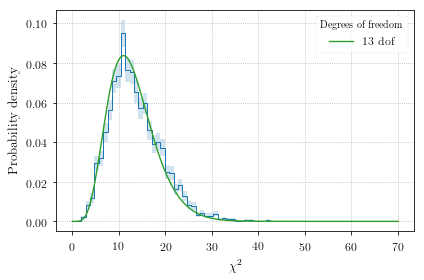

In [221]:
fig, ax = plt.subplots()
chi2_bins, chi2_bins_size = np.linspace(0, 70, 75, retstep=True)
hist_params = {'bins': chi2_bins,
#                'histtype': 'step',
               'alpha': 0.7,
               }

chi2_hist, _ = np.histogram(results.loc[:, 'chi2'].values, bins=chi2_bins)
chi2_hist_err = np.sqrt(chi2_hist)
chi2_pdf = chi2_hist / (chi2_hist.sum() * chi2_bins_size)
chi2_pdf_err = chi2_hist_err / (chi2_hist.sum() * chi2_bins_size)
comp.plot_steps(chi2_bins, chi2_pdf, chi2_pdf_err, ax=ax)

# Include chi-squared PDF for various degrees of freedom
x = np.linspace(0, 70, 200)
num_bins = len(ebins) - 1
print(num_bins)
dof = 13

chi2_pdf = stats.chi2.pdf(x, dof)
ax.plot(x, chi2_pdf,
        marker='None',
        ls='-',
        color='C2',
        label='{} dof'.format(dof))

ax.set_xlabel('$\\chi^2$')
ax.set_ylabel('Probability density')
# ax.set_title('On-region size: {:0.1f}'.format(np.rad2deg(size)) + '$^{\circ}$')
ax.grid()
ax.legend(title='Degrees of freedom')

outfile = os.path.join(figures_outdir,
                       'chi2-hist.png')
comp.check_output_dir(outfile)
plt.savefig(outfile)

plt.show()

Calculate p-value and pre-trial significance

In [222]:
pval = stats.chi2.sf(results['chi2'], dof)
sig = erfcinv(2 * pval) * np.sqrt(2)

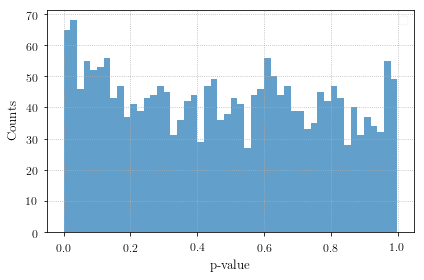

In [223]:
fig, ax = plt.subplots()
hist_params = {'bins': 50,
#                'histtype': 'step',
               'alpha': 0.7,
               }
ax.hist(pval, **hist_params)
ax.set(xlabel='p-value',
       ylabel='Counts')
ax.grid()
ax.legend()

outfile = os.path.join(figures_outdir,
                       'pval-hist.png')
comp.check_output_dir(outfile)
plt.savefig(outfile)

plt.show()

3.5353753954917804


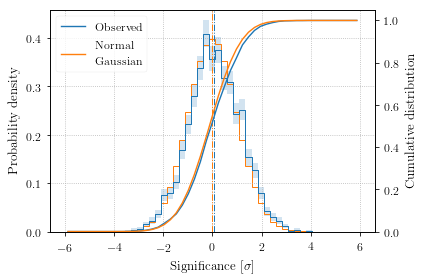

In [224]:
from scipy.special import erfcinv

fig, ax = plt.subplots()
sig_bins, sig_bins_size = np.linspace(-6, 6, 50, retstep=True)
sig_bins_midpoints = comp.binning.bin_edges_to_midpoints(sig_bins)
hist_params = {'bins': sig_bins,
#                'histtype': 'step',
               'alpha': 1.0,
               }

theta, phi = hp.pix2ang(nside, results['pix_center'])
ra, dec = sa.healpy_to_equatorial(theta, phi)

sig_hist, _ = np.histogram(sig, bins=sig_bins)
sig_hist_err = np.sqrt(sig_hist)
sig_pdf = sig_hist / (sig_hist.sum() * sig_bins_size)
sig_pdf_err = sig_hist_err / (sig_hist.sum() * sig_bins_size)
comp.plot_steps(sig_bins, sig_pdf, sig_pdf_err, ax=ax)

ax.axvline(np.median(sig),
           marker='None', ls='-.', lw=1,
           label='Median')

counts, _ = np.histogram(sig, bins=sig_bins)
counts = counts / counts.sum()
ax_cdf = ax.twinx()
ax_cdf.plot(sig_bins_midpoints, np.cumsum(counts), marker='None',
            label='Observed')
ax_cdf.set_ylabel('Cumulative distribution')
ax_cdf.set_ylim(bottom=0)

np.random.seed(2)
normal_samples = np.random.normal(size=int(1e7))
ax.axvline(np.median(normal_samples),
           marker='None', ls='-.', lw=1,
           label='Median', color='C1')
ax.hist(normal_samples, bins=sig_bins, density=True,
        histtype='step', color='C1', alpha=1.0, lw=1.0)

counts, _ = np.histogram(normal_samples, bins=sig_bins)
counts = counts / counts.sum()
ax_cdf.plot(sig_bins_midpoints, np.cumsum(counts), marker='None',
            label='Normal \n Gaussian' )


d, ks_pval = stats.ks_2samp(normal_samples, sig)
print(erfcinv(2 * ks_pval) * np.sqrt(2))


ax.set_xlabel('Significance [$\\sigma$]')
ax.set_ylabel('Probability density')
ax.grid()
ax_cdf.legend()

outfile = os.path.join(figures_outdir,
                       'significance-dist.png')
plt.savefig(outfile)

plt.show()

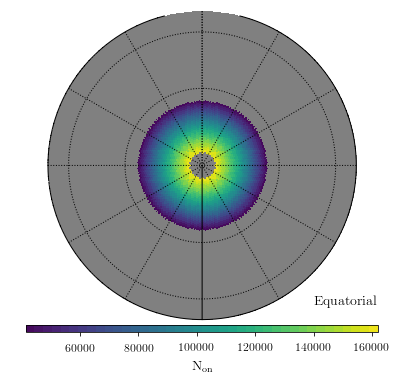

In [225]:
num_on_map = np.full(npix, hp.UNSEEN)
num_on_map[results['pix_center']] = results['num_on']

comp.plot_skymap(num_on_map, cbar_title='$\mathrm{N_{on}}$', polar=True)

outfile = os.path.join(figures_outdir,
                       'num-on-skymap-polar.png')
comp.check_output_dir(outfile)
plt.savefig(outfile)

plt.show()

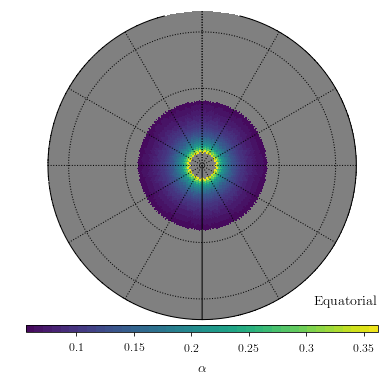

In [80]:
num_on_map = np.full(npix, hp.UNSEEN)
num_on_map[results['pix_center']] = results['alpha']

comp.plot_skymap(num_on_map, cbar_title='$\mathrm{\\alpha}$', polar=True)

outfile = os.path.join(figures_outdir,
                       'alpha-skymap-polar.png')
comp.check_output_dir(outfile)
plt.savefig(outfile)

plt.show()

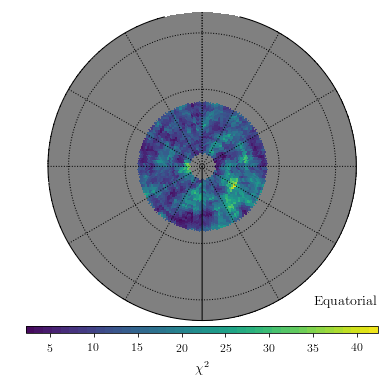

In [226]:
chi2_map = np.full(npix, hp.UNSEEN)
chi2_map[results['pix_center']] = results['chi2']

comp.plot_skymap(chi2_map, cbar_title='$\mathrm{\chi^2}$', polar=True)

outfile = os.path.join(figures_outdir,
                       'chi2-skymap-polar.png')
plt.savefig(outfile)

plt.show()

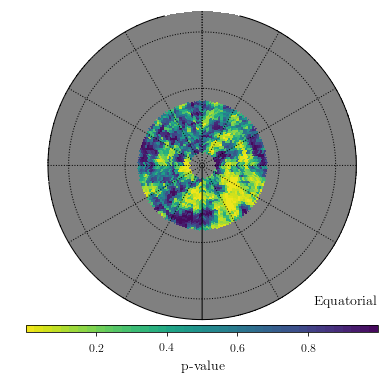

In [158]:
pval_map = np.full(npix, hp.UNSEEN)
pval_map[results['pix_center']] = pval

comp.plot_skymap(pval_map, cbar_title='p-value', polar=True, color_palette='viridis_r')

outfile = os.path.join(figures_outdir,
                       'pval-skymap-polar.png')
plt.savefig(outfile)

plt.show()

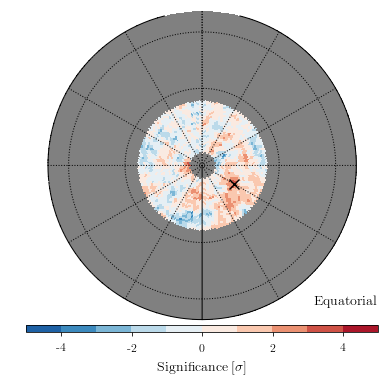

In [159]:
sig_map = np.full(npix, hp.UNSEEN)
sig_map[results['pix_center']] = sig

comp.plot_skymap(sig_map,
                 color_palette='RdBu_r',
                 cbar_min=-5,
                 cbar_max=5,
                 color_bins=10,
                 cbar_title='Significance [$\sigma$]',
                 polar=True)

pix_max_sig = results.loc[sig.argmax(), 'pix_center']
theta_max, phi_max = hp.pix2ang(nside=nside, ipix=pix_max_sig)

hp.projscatter(theta_max, phi_max, marker='x', s=100, c='k')

outfile = os.path.join(figures_outdir,
                       'sig-skymap-polar.png')
plt.savefig(outfile)

plt.show()

In [160]:
sig.min(), sig.max()

(-3.360747906068586, 3.8669994824949883)

In [161]:
def get_significance_map(data_map, ref_map, alpha=1/20.):

    with np.errstate(invalid='ignore', divide='ignore'):
        n_on  = data_map
        n_off = ref_map / alpha

        sign = np.sign(data_map - ref_map)
        sig_map = sign * np.sqrt(2*(n_on*np.log(((1+alpha)*n_on) / (alpha*(n_on+n_off)))
            + n_off * np.log(((1+alpha)*n_off) / (n_on+n_off))))

    return sig_map

In [162]:
theta_max, phi_max = hp.pix2ang(nside=nside, ipix=pix_max_sig)

counts_on_max, counts_on_err_max, counts_off_max, counts_off_err_max = sa.on_off_distributions(
                                binned_maps=binned_skymaps,
                                pix_center=pix_max_sig,
                                on_region=on_region,
                                size=size,
                                off_region=off_region,
                                nside=nside)

In [163]:
ebins_midpoints = (ebins[:-1] + ebins[1:]) / 2
ebins_midpoints

array([6.45, 6.55, 6.65, 6.75, 6.85, 6.95, 7.05, 7.15, 7.25, 7.35, 7.45,
       7.55, 7.65, 7.75])

In [164]:
ebins

array([6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6,
       7.7, 7.8])

In [165]:
counts_on_max

array([[61224, 48534],
       [45374, 36713],
       [30778, 26594],
       [22317, 17217],
       [15201, 10684],
       [10053,  6595],
       [ 5514,  4806],
       [ 3491,  2857],
       [ 2025,  1651],
       [ 1047,  1223],
       [  775,   675],
       [  381,   470],
       [  210,   368],
       [  115,   216],
       [   85,   176],
       [   40,   101],
       [   18,    40],
       [   12,    34],
       [   11,    29]])

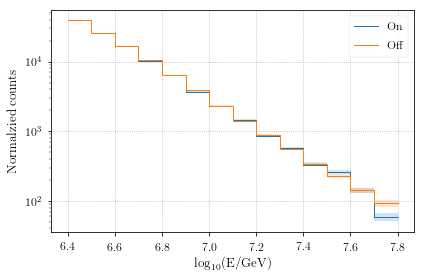

In [166]:
counts_on_max_, _ = unfolding_func(counts_on_max)
counts_off_max_, _ = unfolding_func(counts_off_max)

alpha = np.sum(counts_on_max_) / np.sum(counts_off_max_)
scaled_counts_off_max = alpha * counts_off_max_

fig, ax = plt.subplots()
comp.plot_steps(ebins, counts_on_max_, np.sqrt(counts_on_max_),
                label='On', color='C0', ax=ax)
comp.plot_steps(ebins, scaled_counts_off_max, np.sqrt(scaled_counts_off_max),
                label='Off', color='C1', ax=ax)

ax.set_ylabel('Normalzied counts')
ax.set_xlabel('$\mathrm{\log_{10}(E/GeV)}$')
ax.set_yscale('log', nonposy='clip')
ax.grid()
ax.legend()

outfile = os.path.join(figures_outdir,
                       'max-sig-counts-hist.png')
plt.savefig(outfile)

plt.show()

In [89]:
get_significance_map(counts_on_max_, counts_off_max_, alpha=1/alpha)

array([-263.79192683, -215.05936525, -172.07582901, -136.75256494,
       -106.77941393,  -84.17717326,  -64.66333846,  -49.46913664,
        -39.51709654,  -31.54564139,  -25.06351525,  -19.17561385,
        -16.18627201,  -14.4038147 ])

In [127]:
for r in [3.0, 4.0, 5.0]:
    input_hdf = os.path.join(os.getcwd(), 'data', 'chi2-results-radius-{:0.1f}-degree.hdf'.format(r))
    results = pd.read_hdf(input_hdf)

    sig_map = np.full(npix, hp.UNSEEN)
    sig_map[results['pix_disc']] = results['sig']

    theta, phi = hp.pix2ang(nside, range(npix))
    ra, dec = healpy_to_equatorial(theta, phi)
    sig_map[dec < np.deg2rad(-90) + np.deg2rad(r)] = hp.UNSEEN

    comp.plot_skymap(sig_map,
                     color_palette='RdBu_r',
                     cbar_min=-5, cbar_max=5,
                     cbar_title='Significance [$\sigma$]',
                     polar=True)

    outfile = os.path.join(comp.paths.figures_dir,
                           'skymaps',
                           'radius-{}-degrees'.format(r),
                           '{}-sig-skymap-polar.png'.format(config))
    plt.savefig(outfile)

    plt.show()

NameError: name 'healpy_to_equatorial' is not defined

In [245]:
sig_map.max()

5.005907156818285

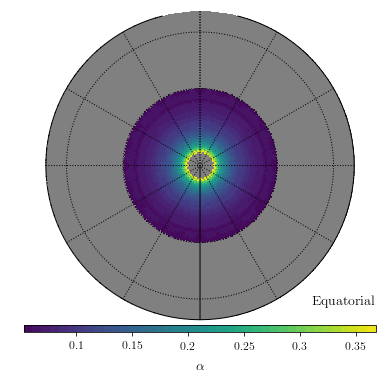

In [246]:
alpha_map = np.full(npix, hp.UNSEEN)
alpha_map[results['pix_disc']] = results['alpha']

theta, phi = hp.pix2ang(nside, range(npix))
ra, dec = healpy_to_equatorial(theta, phi)
alpha_map[dec < np.deg2rad(-90) + radius] = hp.UNSEEN

comp.plot_skymap(alpha_map, cbar_title='$\mathrm{\\alpha}$', polar=True)

outfile = os.path.join(comp.paths.figures_dir,
                       'skymaps',
                       'radius-{}-degrees'.format(np.rad2deg(radius)),
                       '{}-alpha-skymap-polar.png'.format(config))
plt.savefig(outfile)

plt.show()

In [87]:
energy_mask = df_data.loc[:, 'reco_log_energy'] > 7.9
energy = df_data.loc[energy_mask, 'reco_log_energy']
ra = df_data.loc[energy_mask, 'lap_ra']
dec = df_data.loc[energy_mask, 'lap_dec']

theta, phi = equatorial_to_healpy(ra, dec)

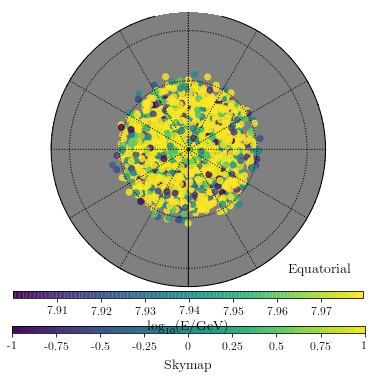

In [103]:
comp.plot_skymap(np.full(npix, hp.UNSEEN), polar=True)
fig = plt.gcf()
ax = plt.gca()

image = hp.projscatter(theta, phi, c=energy, alpha=0.8)
cbar = fig.colorbar(image,
                    orientation='horizontal',
                    aspect=50,
                    pad=0.01,
                    fraction=0.1,
                    ax=ax,
                    format=FormatStrFormatter('%g'),
                    shrink=1.0)
cbar.set_label('$\mathrm{\log_{10}(E/GeV)}$', size=14)
plt.show()